# Cloud Project: Big Data Queries
(This was a project for INFS3208)

James Guanzon

References:

    Practical 10 for the docker-compose.yml & hadoop.env & for example code.
    University of Queensland. "Prac 10." UQ. 
    https://learn.uq.edu.au/webapps/blackboard/content/listContent.jsp?course_id=_150325_1&content_id=_6851097_1

    Dataset used:
    [1] S. Goyal. "Credit Card customers: Predict Churning customers." Kaggle.
    https://www.kaggle.com/sakshigoyal7/credit-card-customers (accessed Oct. 19, 2021).
    
    (just a visual thing) Adding "%" to Y Axis for graph:
    [2] M. Physicist. "Format y axis as percent." stackoverflow.
    https://stackoverflow.com/questions/31357611/format-y-axis-as-percent (accessed Oct. 19, 2021).
    
Goal:
We want to find and understand the various things that predict when customers "churn" (leave / stop using service) for bank credit card services. 

This will be done by making trend/pattern big data queries from [1] dataset and visually displaying the results for a conclusion. The dataset [1] has information on "Credit Card customers" from a bank and if they stopped using their credit card service / closed their account.

### Preprocessing

Read in dataset from HDFS and infer schema / add header. Present in this dataset are two unrelated attributes that have no correlation, get rid of it.

In [1]:
from pyspark.sql import SparkSession
import pandas as pd

spark = SparkSession.builder.appName('churn').getOrCreate()
df = spark.read.csv('hdfs://namenode/BankChurners.csv', header = True, inferSchema = True)
df.printSchema()

df1 = df.drop("Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1").drop("Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2")
pd.DataFrame(df1.take(5), columns=df1.columns).transpose()

root
 |-- CLIENTNUM: integer (nullable = true)
 |-- Attrition_Flag: string (nullable = true)
 |-- Customer_Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Dependent_count: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income_Category: string (nullable = true)
 |-- Card_Category: string (nullable = true)
 |-- Months_on_book: integer (nullable = true)
 |-- Total_Relationship_Count: integer (nullable = true)
 |-- Months_Inactive_12_mon: integer (nullable = true)
 |-- Contacts_Count_12_mon: integer (nullable = true)
 |-- Credit_Limit: double (nullable = true)
 |-- Total_Revolving_Bal: integer (nullable = true)
 |-- Avg_Open_To_Buy: double (nullable = true)
 |-- Total_Amt_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Trans_Amt: integer (nullable = true)
 |-- Total_Trans_Ct: integer (nullable = true)
 |-- Total_Ct_Chng_Q4_Q1: double (nullable = true)
 |-- Avg_Utilization_Ratio: double (n

,0,1,2,3,4
CLIENTNUM,768805383,818770008,713982108,769911858,709106358
Attrition_Flag,Existing Customer,Existing Customer,Existing Customer,Existing Customer,Existing Customer
Customer_Age,45,49,51,40,40
Gender,M,F,M,F,M
Dependent_count,3,5,3,4,3
Education_Level,High School,Graduate,Graduate,High School,Uneducated
Marital_Status,Married,Single,Married,Unknown,Married
Income_Category,$60K - $80K,Less than $40K,$80K - $120K,Less than $40K,$60K - $80K
Card_Category,Blue,Blue,Blue,Blue,Blue
Months_on_book,39,44,36,34,21


### Understanding Data:
The above table gives a better understanding of the data.
We should focus around the "Attrition_Flag", where "Existing Customer" = service in use, "Attrited Customer" = no longer with the service / not in use.

The below table tells us this data has more existing customers than attrited. 

In [2]:
df1.groupBy('Attrition_Flag').count().toPandas()

,Attrition_Flag,count
0,Existing Customer,8500
1,Attrited Customer,1627


These two tables below describe the "Existing Customers" and "Attrited Customer" types. Some clear differences, such as smaller "Revolving Balance" etc.

In [3]:
dfExisting = df1.filter(df1['Attrition_Flag'] == 'Existing Customer')
dfAttrited = df1.filter(df1['Attrition_Flag'] == 'Attrited Customer')

numeric_features = [t[0] for t in df1.dtypes if t[1] == 'int' or t[1] == 'double']
dfExisting.select(numeric_features).describe().toPandas().transpose().style.set_caption('Existing Customers')

,0,1,2,3,4
summary,count,mean,stddev,min,max
CLIENTNUM,8500,7.399272178852941E8,3.7107226536905944E7,708082083,828343083
Customer_Age,8500,46.26211764705882,8.081156782200479,26,73
Dependent_count,8500,2.3354117647058823,1.303228545866282,0,5
Months_on_book,8500,35.88058823529412,8.0218095837889,13,56
Total_Relationship_Count,8500,3.9145882352941177,1.5289492256624813,1,6
Months_Inactive_12_mon,8500,2.273764705882353,1.0167412356411925,0,6
Contacts_Count_12_mon,8500,2.3563529411764708,1.0814356712688244,0,5
Credit_Limit,8500,8726.877517646963,9084.96980712488,1438.3,34516.0
Total_Revolving_Bal,8500,1256.6041176470587,757.7453536936715,0,2517


In [4]:
dfAttrited.select(numeric_features).describe().toPandas().transpose().style.set_caption('Attrited Customer')

,0,1,2,3,4
summary,count,mean,stddev,min,max
CLIENTNUM,1627,7.352613812636755E8,3.557725336048395E7,708083283,828294933
Customer_Age,1627,46.659496004917024,7.665651603482916,26,68
Dependent_count,1627,2.402581438229871,1.275010348451706,0,5
Months_on_book,1627,36.178242163491085,7.796548490955798,13,56
Total_Relationship_Count,1627,3.279655808236017,1.577781736303355,1,6
Months_Inactive_12_mon,1627,2.693300553165335,0.8996230507687535,0,6
Contacts_Count_12_mon,1627,2.972341733251383,1.090537230076184,0,6
Credit_Limit,1627,8136.03945912722,9095.334104641075,1438.3,34516.0
Total_Revolving_Bal,1627,672.8229870928088,921.3855819044372,0,2517


## Spark SQL Query 1: ("% Attrited Customer vs Avg Utilization Ratio")

Below I have focused on "Avg_Utilization_Ratio" as its average seems to be lower for "Attrited Customers" than "Existing Customers" based on the above tables.

    [2]
    "Avg_Utilization_Ratio" = "credit card utilization ratio", which is the amount of credit used on your credit card.
    "Existing Customer" = service in use.
    "Attrited Customer" = no longer with the service / not in use.

I have:

    - Rounded the "Avg_Utilization_Ratio" to nearest 0.5 and grouped them
    - For each ratio group, gotten the % Attrited (people who no longer use service).
    
Query Conclusion:

As seen from the below graph, it can be discerned that customers with LOW or HIGH  "credit card utilization ratio" are more likely to close their credit card account service then those who use it moderately.


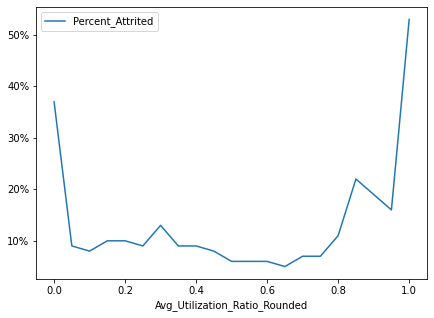

In [5]:
import matplotlib.ticker as mtick

df1.createOrReplaceTempView("bankChurn")
query = """
SELECT 
    ROUND(Avg_Utilization_Ratio * 2, 1) / 2 as Avg_Utilization_Ratio_Rounded, 
    CAST(ROUND(SUM(CASE WHEN Attrition_Flag = 'Attrited Customer' THEN 1 ELSE 0 END) / COUNT(*) * 100) as int) AS Percent_Attrited
FROM bankChurn
GROUP BY Avg_Utilization_Ratio_Rounded
ORDER BY Avg_Utilization_Ratio_Rounded
"""
result = spark.sql(query)

ax = result.toPandas().plot(kind='line', x='Avg_Utilization_Ratio_Rounded', y='Percent_Attrited', figsize=(7, 5))
# [2] put % symbol for y axis.
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

## Spark SQL Query 2: Lowest 10 Avg_Open_To_Buy Customers

    [2]
    "Avg_Open_To_Buy" = "Open to Buy Credit Line"

Query Conclusion:
    Those who have very low Avg_Open_To_Buy are more likely to have closed their account.
    

In [6]:
query = """
SELECT Attrition_Flag, Avg_Open_To_Buy
FROM bankChurn
ORDER BY Avg_Open_To_Buy ASC
LIMIT 10;
"""
result = spark.sql(query)

result.toPandas().transpose().style.set_caption('Lowest 10 Avg_Open_To_Buy Customers')

,0,1,2,3,4,5,6,7,8,9
Attrition_Flag,Attrited Customer,Attrited Customer,Attrited Customer,Attrited Customer,Existing Customer,Attrited Customer,Attrited Customer,Existing Customer,Attrited Customer,Existing Customer
Avg_Open_To_Buy,3.000000,10.000000,14.000000,14.000000,15.000000,24.000000,28.000000,29.000000,36.000000,39.000000


## Spark SQL Query 3: Bank Relation Bar Chart

These three attributes are closely related to the bank and the customer.

    [2]
    "Months_on_book" = "Period of relationship with bank"
    "Months_Inactive_12_mon" = "No. of months inactive in the last 12 months"
    "Contacts_Count_12_mon" = "No. of Contacts in the last 12 months"

Query Conclusion:
    "Relationship" and activity seem to have no indication on customers leaving or not.
    

<AxesSubplot:xlabel='Attrition_Flag'>

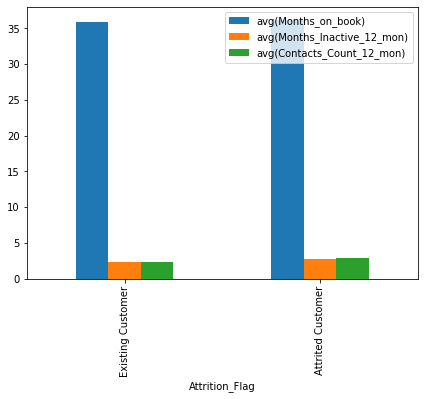

In [7]:
query = """
SELECT Attrition_Flag, AVG(Months_on_book), AVG(Months_Inactive_12_mon), AVG(Contacts_Count_12_mon)
FROM bankChurn
GROUP BY Attrition_Flag
"""
result = spark.sql(query)

result.toPandas().plot(kind='bar', x='Attrition_Flag', figsize=(7, 5))